## Trading Strategy considers only Skewness

In [71]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
# A local binary installation of TA-Lib is required for this to function.
# Alternatively, use the third party (!pip install TA-Lib-binary) wheel that
# bundles the binary (untested & not guaranteed to work).
import talib
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import yfinance as yf
warnings.filterwarnings('ignore')

df = pd.read_csv("results.csv")
df

,Date,^IRX,^SPX,up_prob,down_prob,skewness,kurtosis,mean,variance,median,p10,p90
0,2011-01-07,0.135,1271.500000,0.3169,0.2072,1.0858,-0.3065,1270.7929,41522.7438,1318,1018,1529
1,2011-01-10,0.135,1269.750000,0.3346,0.2386,1.6923,1.4680,1374.2099,122425.1209,1292,999,1550
2,2011-01-11,0.145,1274.479980,0.3283,0.2448,1.6224,1.2034,1273.0806,53592.7590,1312,969,1539
3,2011-01-12,0.145,1285.959961,0.2935,0.2107,1.7602,1.7079,1409.5604,123446.8960,1301,1054,1515
4,2011-01-13,0.140,1283.760010,0.3139,0.2282,1.6123,1.1800,1402.6875,126110.2812,1300,1032,1541
...,...,...,...,...,...,...,...,...,...,...,...,...
2527,2021-01-25,0.070,3855.360107,0.2784,0.1905,1.6098,1.2175,3853.3838,370479.6495,4001,3106,4451
2528,2021-01-26,0.068,3849.620117,0.2814,0.1883,1.4036,0.5250,3847.3655,311757.0274,3983,3158,4511
2529,2021-01-27,0.060,3750.770020,0.3490,0.1511,1.5482,1.0250,3883.0176,249330.5602,3965,3178,4393
2530,2021-01-28,0.055,3787.379883,0.3123,0.1866,1.5422,0.9786,3785.5800,416746.6931,3958,3062,4445


## Priliminary Analysis with Data From the [Minniapolis Fed](https://www.minneapolisfed.org/banking/current-and-historical-market--based-probabilities)

In [72]:
start_date = "2007-01-12"
end_date = "2024-01-24"
market = yf.download("^GSPC", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [73]:
dist = pd.read_csv("mpd_stats.csv", skiprows=3, header=0)

In [74]:
dist["market"] = dist["market"].str.upper()
dist["idt"] = pd.to_datetime(dist["idt"])

In [75]:
dist12m = dist[dist["market"] == "SP12M"]

In [76]:
def moving_average(dist12m, market, n):
    results = []
    for i in range(0, len(dist12m), n):
        window = dist12m.iloc[i:min(i + n, len(dist12m))]
        start_date = window.iloc[0].idt.strftime("%Y-%m-%d")
        end_date = window.iloc[-1].idt.strftime("%Y-%m-%d")
        avg_pr_dec = window['prDec'].mean()
        avg_pr_inc = window['prInc'].mean()
        market_window = market.loc[start_date:end_date]
        future_start = pd.DateOffset(years=1)  + window.iloc[0].idt
        future_end = pd.DateOffset(years=1) + window.iloc[-1].idt
        market_window_future = market.loc[future_start:future_end]
        avg_adj_close_future = market_window_future['Adj Close'].mean()
        avg_adj_close = market_window['Adj Close'].mean()
        down_20 = avg_adj_close * 0.8
        up_20 = avg_adj_close * 1.2
        results.append(pd.DataFrame({
            'start_date': [start_date],
            'end_date': [end_date],
            'avg_pr_dec': [avg_pr_dec],
            'avg_pr_inc': [avg_pr_inc],
            'avg_adj_close': [avg_adj_close],
            'down_20': [down_20],
            'up_20': [up_20],
            'avg_adj_close_future': [avg_adj_close_future],
        }))
    results = pd.concat(results, ignore_index=True)
    return results

mv_avg = moving_average(dist12m, market, 2)

In [77]:
mv_avg.dropna(inplace=True)

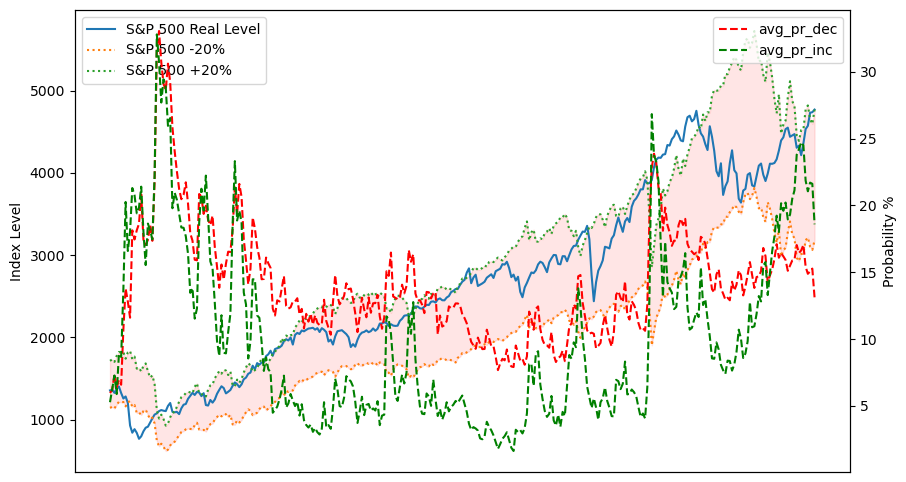

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(mv_avg['start_date'], mv_avg['avg_adj_close_future'], label='S&P 500 Real Level')
plt.plot(mv_avg['start_date'], mv_avg['down_20'], label='S&P 500 -20%', linestyle='dotted')
plt.plot(mv_avg['start_date'], mv_avg['up_20'], label='S&P 500 +20%', linestyle='dotted')
plt.fill_between(mv_avg['start_date'], mv_avg['down_20'], mv_avg['up_20'], color='red', alpha=0.1)
plt.ylabel('Index Level')
plt.legend()
ax2 = plt.twinx()
ax2.plot(mv_avg['start_date'], mv_avg['avg_pr_dec']*100, label='avg_pr_dec', linestyle='dashed', color='red')
ax2.plot(mv_avg['start_date'], mv_avg['avg_pr_inc']*100, label='avg_pr_inc', linestyle='dashed', color='green')
ax2.set_xticks([])
plt.ylabel('Probability %')
plt.legend()
plt.show()


## Skewness Based Strategy - Model Training

In [79]:
train_size = int(len(df) * 0.333)
validation_size = int(len(df) * 0.333)
test_size = len(df) - train_size - validation_size

# Split the data without shuffling
train_set = df[:train_size]
validation_set = df[train_size:train_size + validation_size]
test_set = df[train_size + validation_size:]

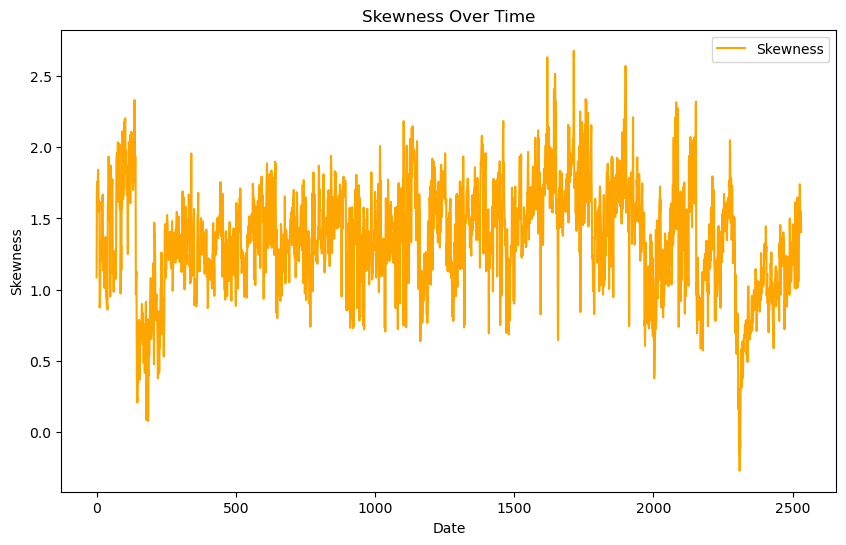

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['skewness'], label='Skewness', color='orange')
plt.title('Skewness Over Time')
plt.xlabel('Date')
plt.ylabel('Skewness')
plt.legend()
plt.show()

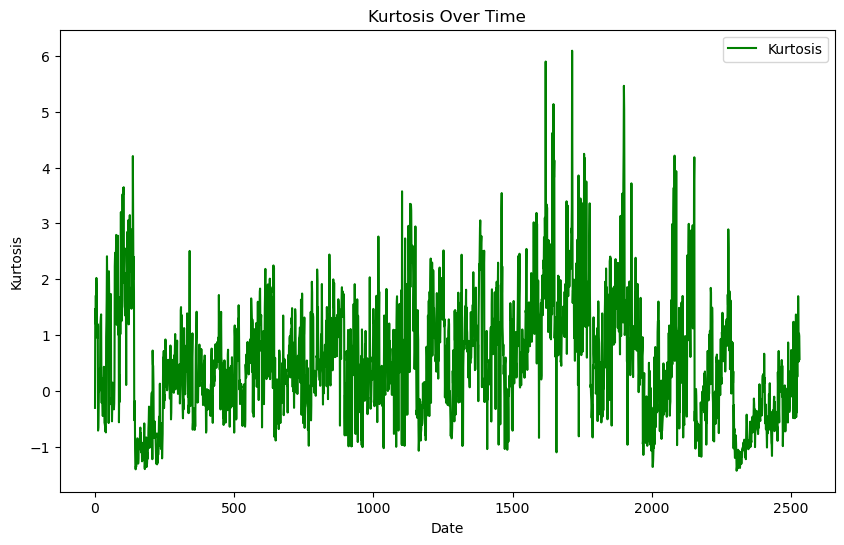

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['kurtosis'], label='Kurtosis', color='green')
plt.title('Kurtosis Over Time')
plt.xlabel('Date')
plt.ylabel('Kurtosis')
plt.legend()
plt.show()

In [82]:
def trading_strategy(df, skewness_buy, skewness_sell):
    position = 0
    cumulative_returns = 0
    buy_price = 0
    signals = []
    for i in range(len(df)):
        signal = 'hold'

        # Check for buy signal
        if df['skewness'].iloc[i-1] > skewness_buy and position == 0:
            signal = 'buy'
            position = 1
            buy_price = df['^SPX'].iloc[i]

        # Check for sell signal
        elif df['skewness'].iloc[i-1] < skewness_sell and position == 1:
            signal = 'sell'
            position = 0
            sell_price = df['^SPX'].iloc[i]
            trade_return = (sell_price - buy_price) / buy_price
            cumulative_returns += trade_return

        signals.append(signal)

    return cumulative_returns, signals

def train_threshold(df, lr, std1, std2):
    best_return = -np.inf
    best_params = {}

    skewness_mean = df['skewness'].mean()
    skewness_std = df['skewness'].std()

    skewness_min = skewness_mean - std1 * skewness_std
    skewness_max = skewness_mean + std1 * skewness_std

    progress_bar = tqdm(total=(len(np.arange(skewness_min, skewness_max, lr)) ** 2))

    for skewness_buy in np.arange(skewness_min, skewness_max, lr):
        for skewness_sell in np.arange(skewness_min, skewness_max, lr):
            total_return, signals = trading_strategy(df, skewness_buy, skewness_sell)
            if total_return > best_return:
                best_return = total_return
                best_params = {
                    'skewness_buy': skewness_buy,
                    'skewness_sell': skewness_sell,
                    'skewness_buy_range': (skewness_buy - std2 * skewness_std, skewness_buy + std2 * skewness_std),
                    'skewness_sell_range': (skewness_sell - std2 * skewness_std, skewness_sell + std2 * skewness_std)
                }
            progress_bar.update(1)
    progress_bar.close()
    return best_return, best_params


## Objective Function in Grid Search

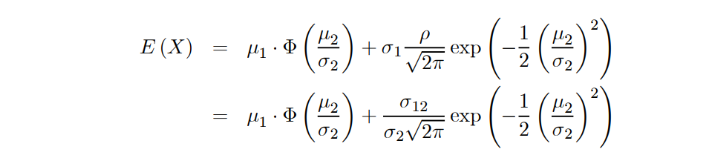

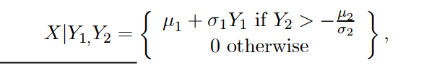

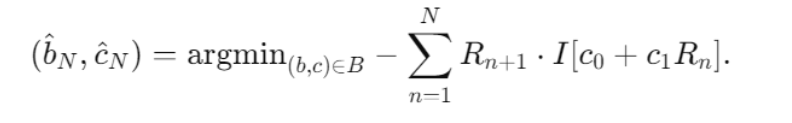

In [83]:
def empirical_risk_minimization(shifted_signals, next_day_returns):
    indicator = [1 if signal == 'buy' else -1 if signal == 'sell' else 0 for signal in shifted_signals]
    empirical_risk = -np.sum(next_day_returns * indicator)
    return empirical_risk

def calculate_expected_profit(df, spx_return, forecasted_cum_returns, y2_forecasted):

    mu_1 = df[spx_return].mean()
    mu_2 = df[forecasted_cum_returns].mean()
    sigma_1 = df[spx_return].std()
    sigma_2 = df[forecasted_cum_returns].std()
    sigma_12 = df[spx_return].cov(df[forecasted_cum_returns])
    rho = df[spx_return].corr(df[forecasted_cum_returns])

    z_score_forecasted = mu_2 / sigma_2
    phi = norm.cdf(z_score_forecasted)
    part1 = mu_1 * phi
    part2 = (sigma_12 / (sigma_2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * z_score_forecasted**2)

    expected_profit = part1 + part2

    return np.where(y2_forecasted > -mu_2 / (sigma_2), expected_profit, 0)

def optimize_thresholds(df, spx_return, forecasted_cum_returns, y2_forecasted, trading_range, lr, patience):

    y2_forecasted_aligned = y2_forecasted.shift(-1).dropna()

    best_score = float('-inf')
    best_expected_profits = 0
    best_empirical_risk = 0
    best_thresholds = {
        'skewness_buy': None,
        'skewness_sell': None
    }
    score_function = lambda profit, risk: profit - risk

    skewness_buy_range = np.arange(*trading_range['skewness_buy_range'], lr)
    skewness_sell_range = np.arange(*trading_range['skewness_sell_range'], lr)

    no_improvement_count = 0  # Counter for early stopping

    # Grid search within the adjusted ranges
    for skewness_buy in skewness_buy_range:
            for skewness_sell in skewness_sell_range:
                    returns, signals = trading_strategy(df, skewness_buy, skewness_sell)
                    empirical_risk = empirical_risk_minimization(signals[:-1], df['spx_return'].iloc[1:].reset_index(drop=True))
                    expected_profits = calculate_expected_profit(df, spx_return, forecasted_cum_returns, y2_forecasted)[0]
                    score = score_function(expected_profits, empirical_risk)

                    if score > best_score:
                        best_score = score
                        best_expected_profits = expected_profits
                        best_empirical_risk = empirical_risk
                        best_thresholds = {
                            'skewness_buy': skewness_buy,
                            'skewness_sell': skewness_sell
                        }
                        no_improvement_count = 0  # Reset counter if there's an improvement
                    else:
                        no_improvement_count += 1  # Increment counter if no improvement

                    # If no improvement for a number of iterations, stop the search
                    if no_improvement_count >= patience:
                        print("Early stopping triggered.")
                        return best_thresholds, best_score, best_expected_profits, best_empirical_risk

    return best_thresholds, best_score, best_expected_profits, best_empirical_risk

def process_in_batches(df, batch_size, spx_return, forecasted_cum_returns, y2_forecasted, trading_range, lr, patience):
    results = []

    # Using tqdm to create a progress bar over the range
    for start in tqdm(range(0, len(df), batch_size), desc='Processing batches'):
        end = min(start + batch_size, len(df))
        df_batch = df.iloc[start:end]
        y2_batch = y2_forecasted[start:end].shift(-1).dropna()  # Align y2_forecasted for each batch

        best_thresholds, best_score, best_expected_profits, best_empirical_risk = optimize_thresholds(df_batch, spx_return, forecasted_cum_returns, y2_batch, trading_range, lr, patience)

        results.append({
            'Batch Start': start,
            'Batch End': end - 1,
            'Skewness Buy Threshold': best_thresholds['skewness_buy'],
            'Skewness Sell Threshold': best_thresholds['skewness_sell'],
            'Best Score': best_score,
            'Min Risk': best_empirical_risk,
            'Max Expected Profit':best_expected_profits

        })

    return pd.DataFrame(results)

In [84]:
# Calculate actual return
train_set['spx_return'] = train_set['^SPX'].pct_change()
validation_set['spx_return'] = validation_set['^SPX'].pct_change()
test_set['spx_return'] = test_set['^SPX'].pct_change()

## Use the final best parameters defined by control variate method to find the best thresholds about skewness_buy, skewness_sell using grid search

In [85]:
# The final optimized parameters by control variate method

lr = 0.2
std1 = 3.0
std2 = 3.0
patience = 5
batch_size = 300

# Next, find the best thresholds skewness_buy and skewness_buy using these optimized parameters

In [86]:
# Get thresholds trained by train_set
best_return, best_params = train_threshold(train_set, lr, std1, std2)

skewness_buy = best_params['skewness_buy']
skewness_sell = best_params['skewness_sell']


# # Calculate forecast return using validation set - forcaste cumulatiev return (Y2) by spx_return (Y1) using signals
returns, signals = trading_strategy(validation_set, skewness_buy, skewness_sell)
validation_set['forecasted_cum_returns'] = 0.0
position = 0
buy = None

for i in range(1, len(validation_set)):
    if signals[i-1] == 'buy' and position == 0:
        position = 1
        buy = i

    if signals[i-1] == 'sell' and position == 1:
        sell = i
        # Calculate cumulative return for the holding period
        validation_set['forecasted_cum_returns'].iloc[buy:sell+1] = validation_set['spx_return'].iloc[buy:sell+1].cumsum()
        position = 0

# After the loop, if the last position was not closed, calculate the cumulative return for the remaining period
if position == 1:
    validation_set['forecasted_cum_returns'].iloc[buy:] = validation_set['spx_return'].iloc[buy:].cumsum()

results_df = process_in_batches(validation_set, batch_size, 'spx_return', 'forecasted_cum_returns', validation_set['forecasted_cum_returns'], best_params, lr, patience)

 87%|████████▋ | 105/121 [00:00<00:00, 170.79it/s]

Processing batches: 100%|██████████| 3/3 [00:00<00:00, 41.38it/s]

Early stopping triggered.
Early stopping triggered.
Early stopping triggered.


In [87]:
results_df

,Batch Start,Batch End,Skewness Buy Threshold,Skewness Sell Threshold,Best Score,Min Risk,Max Expected Profit
0,0,299,-0.74669,1.65331,0.267614,-0.265046,0.002568
1,300,599,-0.74669,1.05331,0.183557,-0.180248,0.003309
2,600,842,-0.74669,2.05331,0.099701,-0.097857,0.001845


Choose the skewness_buy and skewness_sell according to Best Score, which is 0.267614

skewness_buy = -0.74669

skewness_sell = 1.65331

## Backtesting

In [88]:
def benchmark_strategy(df):
    position = 0
    returns = 0
    signals = []

    for i in range(len(df)):
        signal = 'hold'

        if df['up_prob'].iloc[i] > df['down_prob'].iloc[i]:
            if position == 0:  # If not in the market, enter a position
                signal = 'buy'
                position = 1
        elif df['up_prob'].iloc[i] < df['down_prob'].iloc[i]:
            if position == 1:  # If in the market, exit the position and calculate return
                signal = 'sell'
                position = 0
                # Assuming the returns column is named 'spx_return'
                returns += df['spx_return'].iloc[i] if 'spx_return' in df.columns else 0

        signals.append(signal)

    return returns, signals

In [89]:
def cumulated_wealth(df, signals):
    initial_wealth = 1000000
    capital = initial_wealth
    position = 0
    previous_wealth = initial_wealth
    daily_cumulated_returns = []  # List to store daily returns
    daily_returns = []
    peak_wealth = initial_wealth  # Initialize peak wealth
    max_drawdown = 0  # Initialize max drawdown

    for date, signal in zip(df.index, signals):
        price = df.loc[date, '^SPX']
        if signal == 'buy' and capital > 0:
            position = capital / price
            capital = 0
        elif signal == 'sell' and capital == 0:
            capital = position * price
            position = 0

        # Calculate the current wealth (either in capital if not invested, or in position if invested)
        current_wealth = capital if capital > 0 else position * price
        daily_cumulated_return = current_wealth / initial_wealth - 1  # Calculate the daily cumulated return
        daily_cumulated_returns.append(daily_cumulated_return)  # Store the daily return

        daily_return = (current_wealth - previous_wealth) / previous_wealth
        daily_returns.append(daily_return)
        previous_wealth = current_wealth

        # Update peak wealth if current wealth is higher
        if current_wealth > peak_wealth:
            peak_wealth = current_wealth

        # Calculate drawdown as the percentage drop from peak
        drawdown = (peak_wealth - current_wealth) / peak_wealth

        # Update max drawdown if the drawdown is greater than the previous max
        if drawdown > max_drawdown:
            max_drawdown = drawdown

    # Calculate the final wealth and return
    final_wealth = capital if capital > 0 else position * df.iloc[-1]['^SPX']
    final_return = final_wealth / initial_wealth - 1

    return daily_cumulated_returns, final_wealth, final_return, daily_returns, max_drawdown

### Market Baseline Returns

In [90]:
spx_daily_return = test_set['^SPX'].pct_change()

spx_cum_return = ((test_set['^SPX'].pct_change() + 1).cumprod() - 1) * 100
spx_return_daily_volatility = np.std(spx_daily_return, ddof=1)
spx_return_annual_volatility = spx_return_daily_volatility * np.sqrt(252)
print(f"S&P 500 baseline final portfolio value: ${(1 + spx_cum_return.iloc[-1] / 100) * 1000000 :.2f}")
print(f"S&P 500 baseline final return: {spx_cum_return.iloc[-1]:.2f}%")
print(f"S&P 500 baseline daily volatility: {spx_return_daily_volatility:.2%}")
print(f"S&P 500 baseline annual volatility: {spx_return_annual_volatility:.2%}")

S&P 500 baseline final portfolio value: $1480815.23
S&P 500 baseline final return: 48.08%
S&P 500 baseline daily volatility: 1.40%
S&P 500 baseline annual volatility: 22.26%


### Simple Benchmark Strategy

In [91]:
# calculate the benchmark return
benchmark_returns, benchmark_signals = benchmark_strategy(test_set)
benchmark_daily_cumulated_return, benchmark_final_wealth, benchmark_return, benchmark_daily_returns, benchmark_daily_max_drawdown = cumulated_wealth(test_set, benchmark_signals)

print(f"Benchmark final wealth: {benchmark_final_wealth:.2f} dollars")
print(f"Benchmark return: {benchmark_return:.2%}")

# Now we calculate the volatility of the returns
benchmark_volatility = np.std(benchmark_daily_returns, ddof=1)  # ddof=1 for sample standard deviation

# Annualize the volatility if necessary
annualized_volatility = benchmark_volatility * np.sqrt(252)  # Assuming 252 trading days in a year

print(f"Benchmark Daily Volatility: {benchmark_volatility:.2%}")
print(f"Benchmark Annualized Volatility: {annualized_volatility:.2%}")
print(f"Benchmark Maximum Drawdown: {benchmark_daily_max_drawdown:.2%}")

# Use the average of the risk-free rate from the DataFrame for the period considered
risk_free_rate = df['^IRX'].mean()

# Sharpe Ratio
benchmark_sharpe_ratio = (benchmark_return - risk_free_rate) / benchmark_volatility

# Sortino Ratio
benchmark_negative_returns = [x for x in benchmark_daily_returns if x < 0]
benchmark_downside_deviation = np.std(benchmark_negative_returns, ddof=1)
benchmark_sortino_ratio = (benchmark_return - risk_free_rate) / benchmark_downside_deviation

# Win Rate
benchmark_win_rate = len([x for x in benchmark_daily_returns if x > 0]) / len(benchmark_daily_returns)

# Add to the existing print statements
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")
print(f"Benchmark Sortino Ratio: {benchmark_sortino_ratio:.2f}")
print(f"Benchmark Win Rate: {benchmark_win_rate:.2%}")

Benchmark final wealth: 1537539.27 dollars
Benchmark return: 53.75%
Benchmark Daily Volatility: 1.39%
Benchmark Annualized Volatility: 22.11%
Benchmark Maximum Drawdown: 31.63%
Benchmark Sharpe Ratio: -2.51
Benchmark Sortino Ratio: -2.69
Benchmark Win Rate: 53.78%


### Skewness Strategy

In [92]:
# Best thresholds considering only skewness

skewness_buy = -0.74669
skewness_sell = 1.65331

In [93]:
df['spx_return'] = df['^SPX'].pct_change()
trading_strategy_returns, trading_strategy_signals = trading_strategy(test_set, skewness_buy, skewness_sell)
trading_strategy_daily_cumulated_returns, trading_strategy_final_wealth, trading_strategy_return, trading_strategy_daily_returns, trading_strategy_max_drawdown = cumulated_wealth(test_set, trading_strategy_signals)

print(f"Skewness strategy final wealth: {trading_strategy_final_wealth:.2f} dollars")
print(f"Skewness strategy return: {trading_strategy_return:.2%}")

# Now we calculate the volatility of the daily returns
trading_strategy_volatility = np.std(trading_strategy_daily_returns, ddof=1)  # ddof=1 for sample standard deviation

# Annualize the volatility if necessary
annualized_trading_strategy_volatility = trading_strategy_volatility * np.sqrt(252)  # Assuming 252 trading days in a year

print(f"Skewness strategy Daily Volatility: {trading_strategy_volatility:.2%}")
print(f"Skewness strategy Annualized Volatility: {annualized_trading_strategy_volatility:.2%}")

# Calculate the Sharpe Ratio
trading_strategy_sharpe_ratio = (trading_strategy_return - risk_free_rate) / trading_strategy_volatility

# Calculate the Sortino Ratio
trading_strategy_negative_returns = [x for x in trading_strategy_daily_returns if x < 0]
trading_strategy_downside_deviation = np.std(trading_strategy_negative_returns, ddof=1) if trading_strategy_negative_returns else 0
trading_strategy_sortino_ratio = (trading_strategy_return - risk_free_rate) / trading_strategy_downside_deviation if trading_strategy_downside_deviation else None

# Calculate the Win Rate
trading_strategy_win_rate = len([x for x in trading_strategy_daily_returns if x > 0]) / len(trading_strategy_daily_returns)

# Print the performance metrics
print(f"Skewness strategy Sharpe Ratio: {trading_strategy_sharpe_ratio:.2f}")
print(f"Skewness strategy Sortino Ratio: {trading_strategy_sortino_ratio:.2f}" if trading_strategy_sortino_ratio is not None else "Trading Strategy Sortino Ratio: N/A")
print(f"Skewness strategy Win Rate: {trading_strategy_win_rate:.2%}")
print(f"Skewness strategy Maximum Drawdown: {trading_strategy_max_drawdown:.2%}")

Skewness strategy final wealth: 1338553.17 dollars
Skewness strategy return: 33.86%
Skewness strategy Daily Volatility: 0.96%
Skewness strategy Annualized Volatility: 15.25%
Skewness strategy Sharpe Ratio: -24.35
Skewness strategy Sortino Ratio: -22.85
Skewness strategy Win Rate: 33.33%
Skewness strategy Maximum Drawdown: 22.91%


In [94]:
# Best thresholds considering both skewness and kurtosis

skewness_buy1 = 0.282164
skewness_sell1 = 1.782164

In [95]:
df['spx_return'] = df['^SPX'].pct_change()

trading_strategy_returns1, trading_strategy_signals1 = trading_strategy(test_set, skewness_buy1, skewness_sell1)
trading_strategy_daily_cumulated_returns1,trading_strategy_final_wealth1, trading_strategy_return1, trading_strategy_daily_returns1,trading_strategy_max_drawdown1 = cumulated_wealth(test_set, trading_strategy_signals1)

print(f"Skewness strategy(consider kurtosis) final portfolio value: {trading_strategy_final_wealth1:.2f} dollars")
print(f"Skewness strategy(consider kurtosis) final return: {trading_strategy_return1:.2%}")

# Now we calculate the volatility of the daily returns
trading_strategy_volatility1 = np.std(trading_strategy_daily_returns1, ddof=1)  # ddof=1 for sample standard deviation

# Annualize the volatility if necessary
annualized_trading_strategy_volatility1 = trading_strategy_volatility1 * np.sqrt(252)  # Assuming 252 trading days in a year

print(f"Skewness strategy(consider kurtosis) Daily Volatility: {trading_strategy_volatility1:.2%}")
print(f"Skewness strategy(consider kurtosis) Annualized Volatility: {annualized_trading_strategy_volatility1:.2%}")

# Calculate the Sharpe Ratio
trading_strategy_sharpe_ratio1 = (trading_strategy_return1 - risk_free_rate) / trading_strategy_volatility1

# Calculate the Sortino Ratio
trading_strategy_negative_returns1 = [x for x in trading_strategy_daily_returns1 if x < 0]
trading_strategy_downside_deviation1 = np.std(trading_strategy_negative_returns1, ddof=1) if trading_strategy_negative_returns1 else 0
trading_strategy_sortino_ratio1 = (trading_strategy_return1 - risk_free_rate) / trading_strategy_downside_deviation1 if trading_strategy_downside_deviation1 else None

# Calculate the Win Rate
trading_strategy_win_rate1 = len([x for x in trading_strategy_daily_returns1 if x > 0]) / len(trading_strategy_daily_returns1)

# Print the performance metrics
print(f"Skewness strategy(consider kurtosis) Sharpe Ratio: {trading_strategy_sharpe_ratio1:.2f}")
print(f"Skewness strategy(consider kurtosis) Sortino Ratio: {trading_strategy_sortino_ratio1:.2f}" if trading_strategy_sortino_ratio1 is not None else "Trading Strategy Sortino Ratio: N/A")
print(f"Skewness strategy(consider kurtosis) Win Rate: {trading_strategy_win_rate1:.2%}")
print(f"Skewness strategy(consider kurtosis) Maximum Drawdown: {trading_strategy_max_drawdown1:.2%}")

Skewness strategy(consider kurtosis) final portfolio value: 1023478.58 dollars
Skewness strategy(consider kurtosis) final return: 2.35%
Skewness strategy(consider kurtosis) Daily Volatility: 0.92%
Skewness strategy(consider kurtosis) Annualized Volatility: 14.54%
Skewness strategy(consider kurtosis) Sharpe Ratio: -59.92
Skewness strategy(consider kurtosis) Sortino Ratio: -52.19
Skewness strategy(consider kurtosis) Win Rate: 35.22%
Skewness strategy(consider kurtosis) Maximum Drawdown: 34.33%


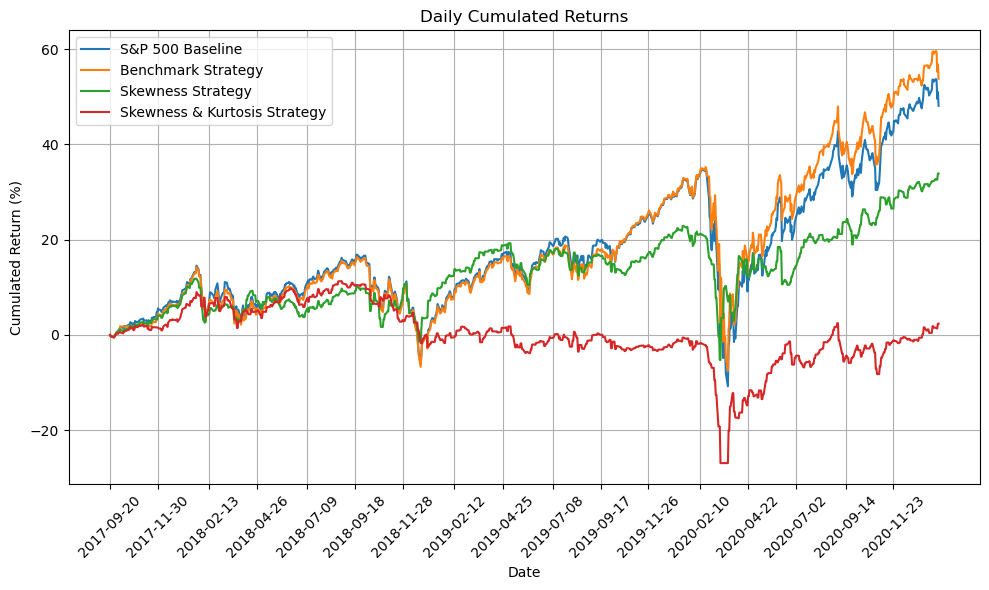

In [96]:
test_set.index = pd.to_datetime(test_set['Date'])

benchmark_daily_cumulated_return_percentage = [x * 100 for x in benchmark_daily_cumulated_return]
trading_strategy_daily_cumulated_returns_percentage = [x * 100 for x in trading_strategy_daily_cumulated_returns]
trading_strategy_daily_cumulated_returns_percentage1 = [x * 100 for x in trading_strategy_daily_cumulated_returns1]

plt.figure(figsize=(10, 6))
plt.plot(test_set.index, spx_cum_return, linestyle='-', label='S&P 500 Baseline')
plt.plot(test_set.index, benchmark_daily_cumulated_return_percentage, linestyle='-', label='Benchmark Strategy')
plt.plot(test_set.index, trading_strategy_daily_cumulated_returns_percentage, linestyle='-', label='Skewness Strategy')
plt.plot(test_set.index, trading_strategy_daily_cumulated_returns_percentage1, linestyle='-', label='Skewness & Kurtosis Strategy')

plt.title('Daily Cumulated Returns')
plt.xlabel('Date')
plt.ylabel('Cumulated Return (%)')
plt.grid(True)

date_ticks = test_set.index[::50]
plt.xticks(date_ticks, [dt.strftime('%Y-%m-%d') for dt in date_ticks], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()


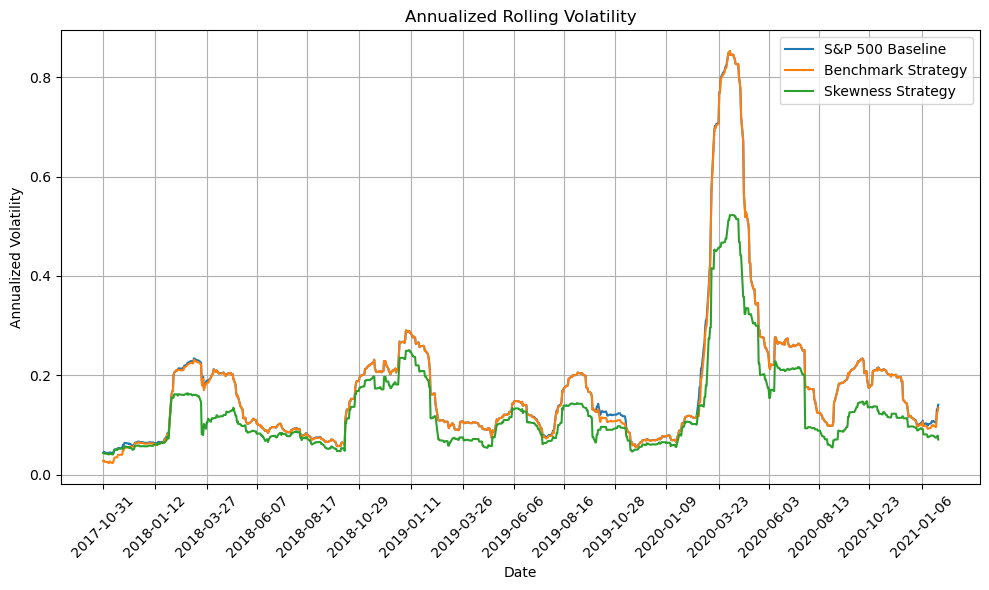

In [97]:
test_set.index = pd.to_datetime(test_set.index)

rolling_window_size = 30
actual_rolling_volatility = test_set['spx_return'].rolling(window=rolling_window_size).std(ddof=1)
annualized_actual_rolling_volatility = actual_rolling_volatility * np.sqrt(252)

benchmark_rolling_volatility = pd.Series(benchmark_daily_returns).rolling(window=rolling_window_size).std(ddof=1)
annualized_benchmark_rolling_volatility = benchmark_rolling_volatility * np.sqrt(252)

trading_strategy_rolling_volatility = pd.Series(trading_strategy_daily_returns).rolling(window=rolling_window_size).std(ddof=1)
annualized_trading_strategy_rolling_volatility = trading_strategy_rolling_volatility * np.sqrt(252)

plt.figure(figsize=(10, 6))

valid_start = rolling_window_size - 1
plt.plot(test_set.index[valid_start:], annualized_actual_rolling_volatility[valid_start:], linestyle='-', label='S&P 500 Baseline')
plt.plot(test_set.index[valid_start:], annualized_benchmark_rolling_volatility[valid_start:], linestyle='-', label='Benchmark Strategy')
plt.plot(test_set.index[valid_start:], annualized_trading_strategy_rolling_volatility[valid_start:], linestyle='-', label='Skewness Strategy')

plt.title('Annualized Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)

date_ticks = test_set.index[valid_start:][::50]
plt.xticks(date_ticks, [dt.strftime('%Y-%m-%d') for dt in date_ticks], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

valid_benchmark_volatility = annualized_benchmark_rolling_volatility[valid_start:].dropna()
valid_strategy_volatility = annualized_trading_strategy_rolling_volatility[valid_start:].dropna()
valid_actual_volatility = annualized_actual_rolling_volatility[valid_start:].dropna()

min_length = min(len(valid_benchmark_volatility), len(valid_strategy_volatility), len(valid_actual_volatility))
correlation_benchmark = np.corrcoef(valid_actual_volatility[:min_length], valid_benchmark_volatility[:min_length])[0, 1]
correlation_strategy = np.corrcoef(valid_actual_volatility[:min_length], valid_strategy_volatility[:min_length])[0, 1]

# MSE
mse_benchmark = mean_squared_error(valid_actual_volatility[:min_length], valid_benchmark_volatility[:min_length])
mse_strategy = mean_squared_error(valid_actual_volatility[:min_length], valid_strategy_volatility[:min_length])

# MAE
mae_benchmark = mean_absolute_error(valid_actual_volatility[:min_length], valid_benchmark_volatility[:min_length])
mae_strategy = mean_absolute_error(valid_actual_volatility[:min_length], valid_strategy_volatility[:min_length])

print("Benchmark Correlation:", correlation_benchmark)
print("Trading Strategy Correlation:", correlation_strategy)
print("Benchmark MSE:", mse_benchmark)
print("Trading Strategy MSE:", mse_strategy)
print("Benchmark MAE:", mae_benchmark)
print("Trading Strategy MAE:", mae_strategy)

Benchmark Correlation: 0.9956457160032358
Trading Strategy Correlation: 0.9693320165600271
Benchmark MSE: 0.00018510996694392587
Trading Strategy MSE: 0.006008150871686315
Benchmark MAE: 0.00672058388229695
Trading Strategy MAE: 0.04767806900568253


### Enhancement Attempt with Decision Tree Strategy

In [99]:
_, training_signals = trading_strategy(train_set, skewness_buy, skewness_sell)

In [100]:
vix = yf.download("^VIX", start="2011-01-07", end="2021-01-30")
vix.index = vix.index.strftime("%Y-%m-%d")
dist_data = pd.read_csv("results.csv")
tree_data = dist_data.merge(vix, left_on="Date", right_on="Date", how="left")[
    ["Date", "^SPX", "skewness", "kurtosis", "up_prob", "down_prob", "Adj Close"]
]
tree_data.rename(columns={"Adj Close": "VIX"}, inplace=True)
tree_data.loc[:, "prob_diff"] = tree_data["up_prob"] - tree_data["down_prob"]
tree_data["spx_up"] = tree_data["^SPX"] > tree_data["^SPX"].shift(1)

tree_data["macd"], tree_data["macdsignal"], tree_data["macdhist"] = talib.MACD(
    tree_data["^SPX"], fastperiod=12, slowperiod=26, signalperiod=9
)
tree_data["rsi"] = talib.RSI(tree_data["^SPX"], timeperiod=14)

for column in ["macd", "macdsignal", "macdhist", "rsi"]:
    tree_data[column].fillna(tree_data[column].mean(), inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [101]:
training = tree_data.loc[:842]
testing = tree_data.loc[1686:]

clf = DecisionTreeClassifier(random_state=42)
training_signals = [[0,1,2][['hold', 'buy', 'sell'].index(signal)] for signal in training_signals]
testing_signals = [[0,1,2][['hold', 'buy', 'sell'].index(signal)] for signal in trading_strategy_signals]
training['trading_signals'] = training_signals
testing['trading_signals'] = testing_signals
clf.fit(training[["skewness", 'prob_diff', 'trading_signals', "macdhist", "rsi"]], training['spx_up'])
y_pred = clf.predict(testing[["skewness", 'prob_diff', 'trading_signals', "macdhist", "rsi"]])
score = accuracy_score(testing['spx_up'], y_pred)
print(score)

0.5401891252955082


In [102]:
i = 0
portfolio2 = [100000]
has_cash = False
shares = 100000 / testing.iloc[0]['^SPX']
benchmark2 = 100000 * testing['^SPX'] / testing.iloc[0]['^SPX']
for row in testing.itertuples():
    if y_pred[i] and has_cash:
        shares = portfolio2[-1] / row._2
        portfolio2.append(portfolio2[-1])
        has_cash = False
    elif not y_pred[i] and not has_cash:
        portfolio2.append(shares * row._2)
        shares = 0
        has_cash = True
    else:
        if has_cash:
            portfolio2.append(portfolio2[-1])
        else:
            portfolio2.append(shares * row._2)
    i += 1

In [103]:
portfolio2 = np.array(portfolio2)
benchmark2 = np.array(benchmark2)

In [104]:
dtree_cum_returns = portfolio2[1:] / 100000 - 1
dtree_daily_returns = dtree_cum_returns[1:] - dtree_cum_returns[:-1]
dtree_daily_returns = np.concatenate([[portfolio2[1] / 100000 - 1], dtree_daily_returns])
dtree_daily_volatility = np.std(dtree_daily_returns, ddof=1)
dtree_annual_volatility = dtree_daily_volatility * np.sqrt(252)
print(f"Decision tree strategy final portfolio: {portfolio2[-1]:.2f} dollars")
print(f"Decision tree strategy final return: {dtree_cum_returns[-1]:.2%}")
print(f"Decision tree strategy daily volatility: {dtree_daily_volatility:.2%}")
print(f"Decision tree strategy annual volatility: {dtree_annual_volatility:.2%}")

Decision tree strategy final portfolio: 170022.02 dollars
Decision tree strategy final return: 70.02%
Decision tree strategy daily volatility: 1.14%
Decision tree strategy annual volatility: 18.11%


## Performance Comparison

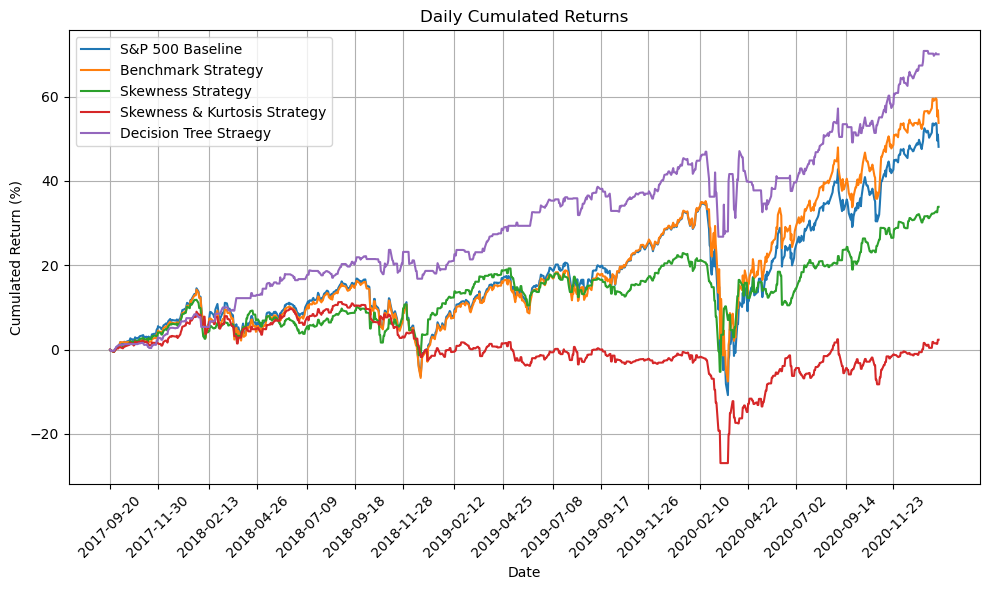

In [105]:
test_set.index = pd.to_datetime(test_set['Date'])

benchmark_daily_cumulated_return_percentage = [x * 100 for x in benchmark_daily_cumulated_return]
trading_strategy_daily_cumulated_returns_percentage = [x * 100 for x in trading_strategy_daily_cumulated_returns]
trading_strategy_daily_cumulated_returns_percentage1 = [x * 100 for x in trading_strategy_daily_cumulated_returns1]

plt.figure(figsize=(10, 6))
plt.plot(test_set.index, spx_cum_return, linestyle='-', label='S&P 500 Baseline')
plt.plot(test_set.index, benchmark_daily_cumulated_return_percentage, linestyle='-', label='Benchmark Strategy')
plt.plot(test_set.index, trading_strategy_daily_cumulated_returns_percentage, linestyle='-', label='Skewness Strategy')
plt.plot(test_set.index, trading_strategy_daily_cumulated_returns_percentage1, linestyle='-', label='Skewness & Kurtosis Strategy')
plt.plot(test_set.index, dtree_cum_returns * 100, linestyle='-', label='Decision Tree Straegy')

plt.title('Daily Cumulated Returns')
plt.xlabel('Date')
plt.ylabel('Cumulated Return (%)')
plt.grid(True)

date_ticks = test_set.index[::50]
plt.xticks(date_ticks, [dt.strftime('%Y-%m-%d') for dt in date_ticks], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()


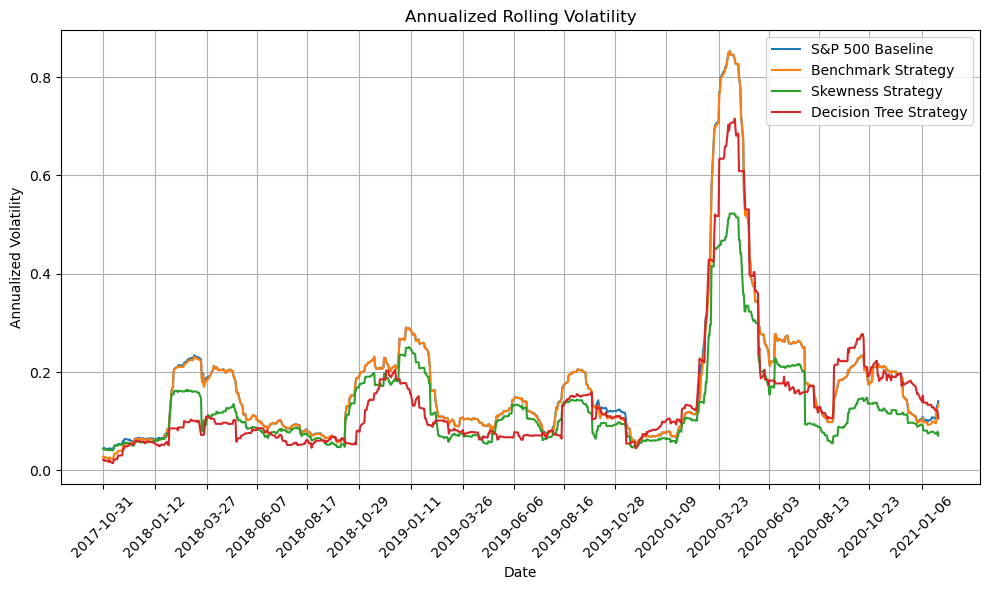

In [106]:
test_set.index = pd.to_datetime(test_set.index)

rolling_window_size = 30
actual_rolling_volatility = test_set['spx_return'].rolling(window=rolling_window_size).std(ddof=1)
annualized_actual_rolling_volatility = actual_rolling_volatility * np.sqrt(252)

benchmark_rolling_volatility = pd.Series(benchmark_daily_returns).rolling(window=rolling_window_size).std(ddof=1)
annualized_benchmark_rolling_volatility = benchmark_rolling_volatility * np.sqrt(252)

trading_strategy_rolling_volatility = pd.Series(trading_strategy_daily_returns).rolling(window=rolling_window_size).std(ddof=1)
annualized_trading_strategy_rolling_volatility = trading_strategy_rolling_volatility * np.sqrt(252)

dtree_rolling_volatility = pd.Series(dtree_daily_returns).rolling(window=rolling_window_size).std(ddof=1)
annualized_dtree_rolling_volatility = dtree_rolling_volatility * np.sqrt(252)

plt.figure(figsize=(10, 6))

valid_start = rolling_window_size - 1
plt.plot(test_set.index[valid_start:], annualized_actual_rolling_volatility[valid_start:], linestyle='-', label='S&P 500 Baseline')
plt.plot(test_set.index[valid_start:], annualized_benchmark_rolling_volatility[valid_start:], linestyle='-', label='Benchmark Strategy')
plt.plot(test_set.index[valid_start:], annualized_trading_strategy_rolling_volatility[valid_start:], linestyle='-', label='Skewness Strategy')
plt.plot(test_set.index[valid_start:], annualized_dtree_rolling_volatility[valid_start:], linestyle='-', label='Decision Tree Strategy')

plt.title('Annualized Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.grid(True)

date_ticks = test_set.index[valid_start:][::50]
plt.xticks(date_ticks, [dt.strftime('%Y-%m-%d') for dt in date_ticks], rotation=45)

plt.legend()

plt.tight_layout()
plt.show()
